In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [12]:
device = "mps"
block_size = 100
test_size = 1500
batch_size = 64

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [13]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=44, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x + F.sigmoid(self.q(x)) * F.pad(x[:, :T-1, :], (0, 0, 1, 0))
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=30, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 95.9 K
-------------------------------
95.9 K    Trainable params
0         Non-trainable params
95.9 K    Total params
0.384     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 45.80it/s]And nowBae

"
-Q
UU-<-DBBTTTJJVöUC"N4R""9caa]"UYY33WYm
e

-QUB-"N44"--D
Epoch 2: 100%|██████████| 118/118 [00:02<00:00, 48.61it/s, loss=1.66, v_num=113, test_loss=1.870]And now, "Yest, thing boy mighter.

"Oh, see was should gol to be to wh
Epoch 5: 100%|██████████| 118/118 [00:02<00:00, 47.69it/s, loss=1.54, v_num=113, test_loss=1.550]And now, and a smell, I will," answer maken and which."

"Alaily, I are
Epoch 6: 100%|██████████| 118/118 [00:02<00:00, 47.47it/s, loss=1.52, v_num=113, test_loss=1.550]And now it come a giostions.

When the lorn old then I'll spleast pleps
Epoch 7: 100%|██████████| 118/118 [00:02<00:00, 47.99it/s, loss=1.51, v_num=113, test_loss=1.520]And now."

"It is front tle to to the othunder spit any have on himself
Epoch 9: 100%|██████████| 118/118 [00:02<00:00, 47.62it/s, loss=1.48, v_num=113, test_loss=1.530]And nows, who did sees in."

"And son, of the stayelive on this, but I 
Epoch 10

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 118/118 [00:02<00:00, 40.95it/s, loss=1.4, v_num=113, test_loss=1.390]


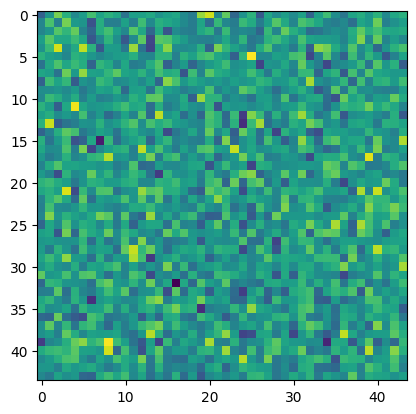

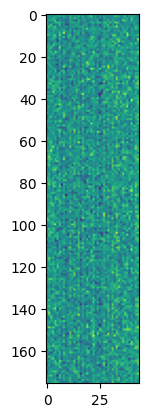

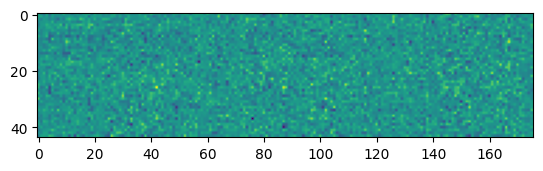

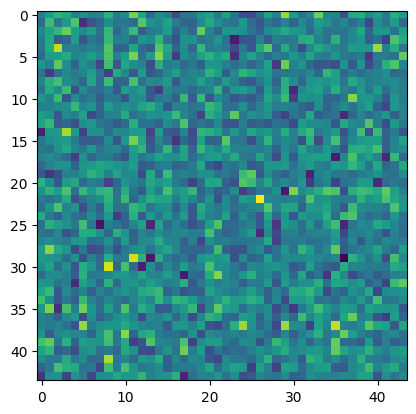

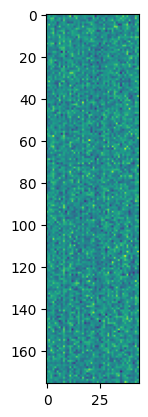

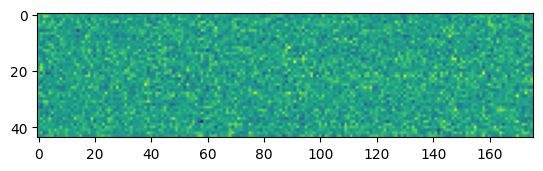

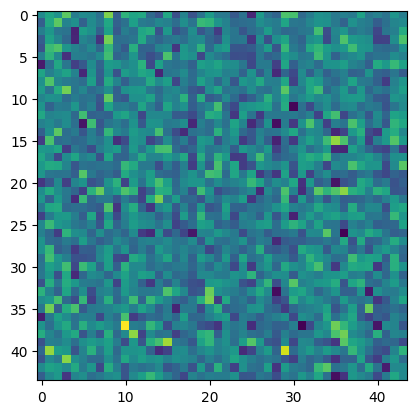

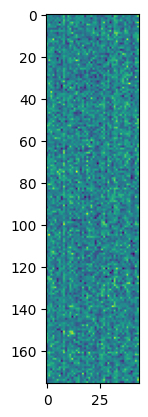

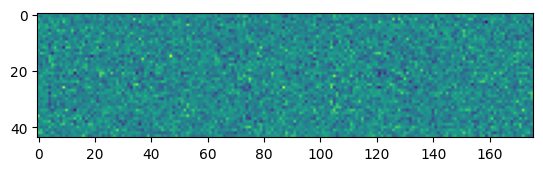

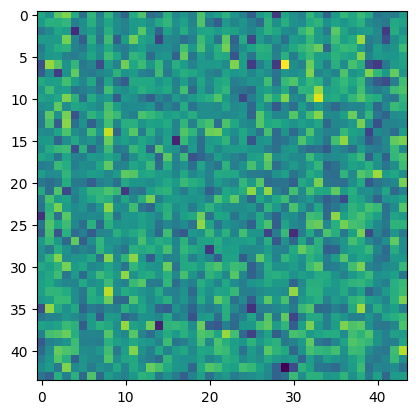

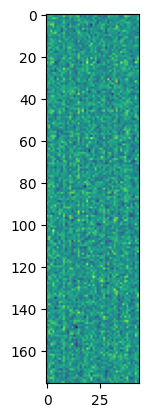

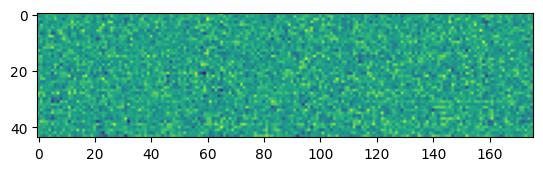

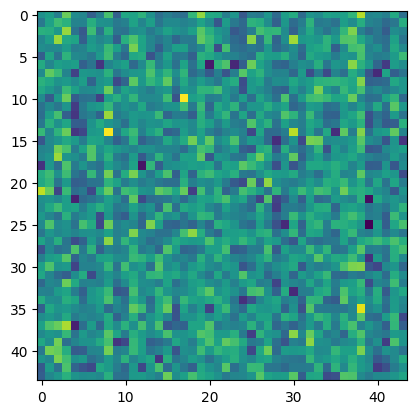

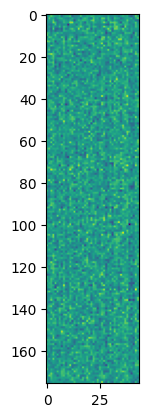

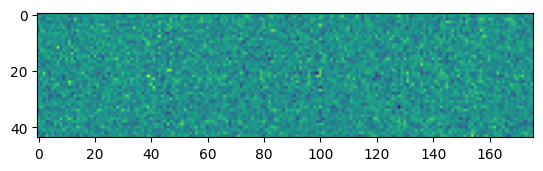

In [14]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [15]:
print(model.generate("O God, O God!", 650))

O God, O God!" said Tum Tum Tum.

"That she's no had not keep! I cannot to found on him for in the first. The two monkeys that their could note of the lining and she added him, for she put the fire ormart with all readed as it him, he said: And I did on me to can care, and the ponished his came writs' though to, she did he. You'd grew shoes again; for why there have a lugrass the mole."

In the children his heat, and carrying:

"What see he cough you will he tree if through sprone on the beat," rapeze, as sheral in the spot.

I shouth.

They may for weight take a pieces on on their way which he sea, and son's hurry home we got there a fly to the fondents 
